# 淋巴细胞受体可变区测序

5' 端 RNA 测序可以选择测量 TCR 基因的高可变区，这是一组天然的谱系追踪标记，在 T 细胞成熟
过程中确定并在子代中不再改变

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em

# set working directory
em.setwd('/home/data/yangz/shared/tutorial/single-cell-rna')

In [3]:
ver = em.version()

[i] exprmat 0.1.48 / exprmat-db 0.1.48
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/shared/tutorial/single-cell-rna
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.48)
[i] resident memory: 808.52 MiB
[i] virtual memory: 5.78 GiB


我们需要 10X 流程给出的两组数据，一组是配套的 RNA 测序数据，另一个需要二级数据表 filtered_contig_annotations.csv

In [4]:
! tree -sh src/pbmc-tcr

src/pbmc-tcr
├── [4.0K]  rna
│   ├── [ 63K]  barcodes.tsv.gz
│   ├── [334K]  features.tsv.gz
│   └── [ 96M]  matrix.mtx.gz
└── [4.0K]  tcr
    ├── [ 33M]  airr_rearrangement.tsv
    ├── [178K]  cell_barcodes.json
    ├── [877K]  clonotypes.csv
    ├── [2.0M]  concat_ref.bam
    ├── [772K]  concat_ref.bam.bai
    ├── [9.3M]  concat_ref.fasta
    ├── [534K]  concat_ref.fasta.fai
    ├── [6.1M]  consensus_annotations.csv
    ├── [1.4M]  consensus.bam
    ├── [772K]  consensus.bam.bai
    ├── [5.3M]  consensus.fasta
    ├── [517K]  consensus.fasta.fai
    ├── [ 14K]  donor_regions.fa
    ├── [8.6M]  filtered_contig_annotations.csv
    ├── [7.7M]  filtered_contig.fasta
    └── [ 15M]  filtered_contig.fastq

2 directories, 19 files


In [5]:
meta = em.metadata(
    locations    = [
        'src/pbmc-tcr/rna',
        'src/pbmc-tcr/tcr',
    ],
    modality     = ['rna', 'rna.tcr'],
    default_taxa = ['hsa', 'hsa'],
    batches      = ['b-1', 'b-1'],
    names        = ['pbmc', 'pbmc'],
    groups       = ['pbmc', 'pbmc'],
)

In [6]:
meta.dataframe

,location,sample,batch,group,modality,taxa
0,src/pbmc-tcr/rna,pbmc,b-1,pbmc,rna,hsa
1,src/pbmc-tcr/tcr,pbmc,b-1,pbmc,rna.tcr,hsa


In [10]:
expm = em.experiment(meta, dump = 'tcr')

[i] reading sample pbmc [rna] ...
[!] load pre-exisiting file `rna/pbmc.h5ad`.
[i] reading sample pbmc [rna.tcr] ...


现在，TCR 表并没有加入数据集中，TCR 对应细胞的查找和整合发生在 merge 函数中

### 质量控制和可视化

我们首先对数据集进行基本的清洗

In [14]:
expm.run_rna_qc(
    run_on_samples = True,
    mt_seqid = 'chrM',
    mt_percent = 0.15,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 5,
    doublet_method = 'no',
    min_cells = 3,
    min_genes = 50
)

[i] found 13 mitochondrial genes (expected 13)
[i] found 102 ribosomal genes
quality controlling sample [pbmc] ...
raw dataset contains 13409 cells, 26253 genes
filtered dataset contains 12641 cells, 22325 genes


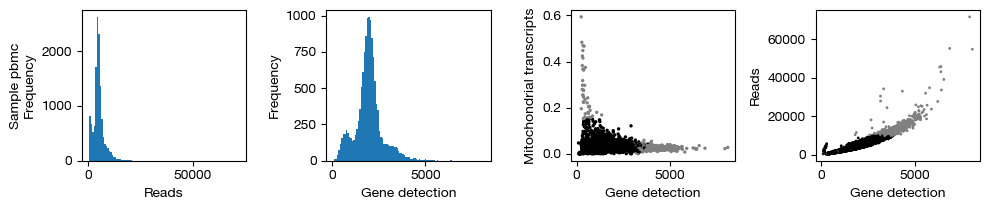

In [15]:
figs = expm.plot_rna_qc(run_on_samples = True)

In [16]:
expm.run_rna_qc(
    run_on_samples = True,
    mt_seqid = 'chrM',
    mt_percent = 0.15,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 5,
    doublet_method = 'scrublet',
    min_cells = 3,
    min_genes = 800
)

[i] found 13 mitochondrial genes (expected 13)
[i] found 102 ribosomal genes
quality controlling sample [pbmc] ...
raw dataset contains 13409 cells, 26253 genes
[i] preprocessing observation count matrix ...
[i] simulating doublets ...
[i] embedding using pca ...
[i] calculating doublet scores ...
[i] detected doublet rate: 3.7 %
[i] estimated detectable doublet fraction: 80.5 %
[i] overall doublet rate: 4.6 %
filtered dataset contains 11229 cells, 22165 genes


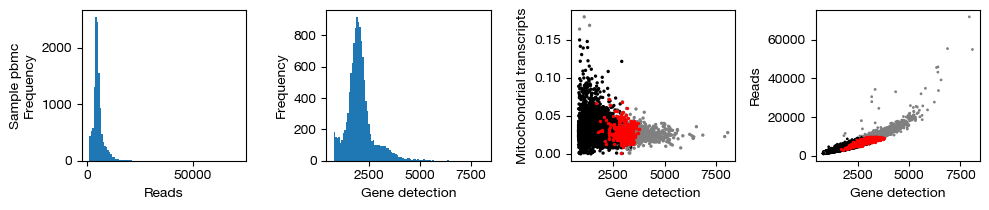

In [17]:
figs = expm.plot_rna_qc(run_on_samples = True)

In [18]:
expm.run_rna_filter(run_on_samples = True)

In [21]:
expm.run_rna_log_normalize(
    run_on_samples = True,
    key_norm = 'norm',
    key_lognorm = 'lognorm'
)

expm.run_rna_select_hvg(
    run_on_samples = True,
    key_lognorm = 'lognorm',
    method = 'vst',
    dest = 'vst',
    n_top_genes = 1500
)

expm.merge(join = 'outer')

[i] reading tcr table from tcr/tcr/pbmc.tsv.gz ...
[!] tcr table contains 1289 duplicated contigs for one cell.
[!] 5463 out of 6154 (88.8%) tcr detections mapped.
[i] 11229 out of 11229 (100.0%) tcr detections mapped.


在整合过程中，TCR 数据集会自动加载并比对到对应细胞中，填充在 obs 列

In [22]:
print(expm)

annotated data of size 11229 × 22165
integrated dataset of size 11229 × 22165
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          tra <o> trb <o> clone <o> clone.id <o> trav <o> traj <o> trbv <o> trbj <o>
    var : chr <o> start <i64> end <i64> strand <o> id <o> subtype <o> gene <o> tlen <f64>
          cdslen <i64> assembly <o> uid <o>
 layers : counts <f32>

[*] composed of samples:
  pbmc    rna   hsa    batch b-1     of size 11229 × 22165



In [24]:
expm['rna'].obs[['clone.id', 'trav', 'traj', 'trbv', 'trbj']]

,clone.id,trav,traj,trbv,trbj
pbmc:2,pbmc:c:1,TRAV21,TRAJ41,TRBV11-1,TRBJ2-2
pbmc:3,pbmc:c:2,TRAV19,TRAJ17,TRBV20-1,TRBJ2-7
pbmc:4,na,na,na,na,na
pbmc:5,pbmc:c:3,TRAV38-2/DV8,TRAJ53,TRBV5-1,TRBJ1-4
pbmc:6,pbmc:c:4,TRAV14/DV4,TRAJ54,TRBV2,TRBJ2-3
...,...,...,...,...,...
pbmc:13403,pbmc:c:5132,TRAV8-4,TRAJ26,TRBV2,TRBJ2-2
pbmc:13404,na,na,na,na,na
pbmc:13407,na,na,na,na,na
pbmc:13408,na,na,na,na,na


### 降维和分群

In [27]:
expm.run_rna_select_hvg(
    key_lognorm = 'X',
    method = 'vst',
    dest = 'vst',
    batch_key = 'batch',
    n_top_genes = 1500
)

expm.run_rna_scale_pca(
    hvg = 'vst.hvg',
    key_lognorm = 'X',
    key_scaled = 'scaled',
    key_added = 'pca', n_comps = 35,
    keep_sparse = False,
    random_state = 42,
    svd_solver = 'arpack'
)

expm.run_rna_knn(
    use_rep = 'pca',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'nn30'
)

expm.run_rna_umap(
    min_dist = 0.3,
    spread = 1,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "nn30"
)

In [28]:
expm.run_rna_leiden(
    resolution = 0.5,
    restrict_to = None,
    random_state = 42,
    key_added = 'leiden',
    adjacency = None,
    directed = None,
    use_weights = True,
    n_iterations = 2,
    partition_type = None,
    neighbors_key = 'nn30',
    obsp = None,
    flavor = 'igraph'
)

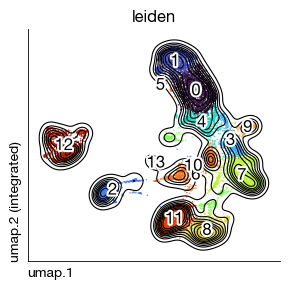

In [29]:
fig = expm.plot_rna_embedding(
    basis = 'umap', color = 'leiden',
    figsize = (3, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 1, annotate_style = 'text', contour_plot = True
)

### TCR 多样性分析

计算 TCR 的基本统计信息

In [30]:
expm.run_rna_calculate_tcr_metrics(expanded_clone = 5)

In [31]:
print(expm)

annotated data of size 11229 × 22165
integrated dataset of size 11229 × 22165
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          tra <o> trb <o> clone <o> clone.id <o> trav <o> traj <o> trbv <o> trbj <o> leiden <cat>
          trab <bool> tcr.clone.sum <i64> tcr.clone.size <i64> tcr.expanded <bool>
          tcr.clone.size.rel <f64>
    var : chr <o> start <i64> end <i64> strand <o> id <o> subtype <o> gene <o> tlen <f64>
          cdslen <i64> assembly <o> uid <o> vst.means <f64> vst.vars <f64> vst.vars.norm <f64>
          vst.hvg.rank <f32> vst.hvg <bool>
 layers : counts <f32>
   obsm : pca <arr:f64(35)> knn.nn30 <arr:i32(30)> knn.d.nn30 <arr:f32(30)> umap <arr:f32(2)>
   varm : pca <arr:f64(35)>
   obsp : 

In [32]:
expm['rna'].obs[['trab', 'tcr.clone.sum', 'tcr.clone.size', 'tcr.expanded']]

,trab,tcr.clone.sum,tcr.clone.size,tcr.expanded
pbmc:2,True,5463,1,False
pbmc:3,True,5463,1,False
pbmc:4,False,5463,0,False
pbmc:5,True,5463,1,False
pbmc:6,True,5463,1,False
...,...,...,...,...
pbmc:13403,True,5463,1,False
pbmc:13404,False,5463,0,False
pbmc:13407,False,5463,0,False
pbmc:13408,False,5463,0,False


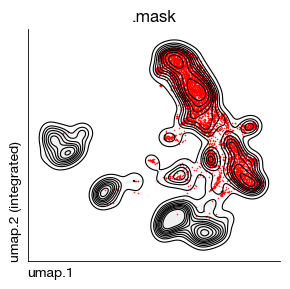

In [36]:
fig = expm.plot_rna_embedding_mask(
    basis = 'umap', color = 'trab', values = [True],
    figsize = (3, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 1, annotate_style = 'text', contour_plot = True
)

In [37]:
expm.run_rna_calculate_startracs_metrics()

In [43]:
print(expm)

annotated data of size 11229 × 22165
integrated dataset of size 11229 × 22165
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          tra <o> trb <o> clone <o> clone.id <o> trav <o> traj <o> trbv <o> trbj <o> leiden <cat>
          trab <bool> tcr.clone.sum <i64> tcr.clone.size <i64> tcr.expanded <bool>
          tcr.clone.size.rel <f64> tcr.cluster.expansion <f64> tcr.cluster.plasticity <f64>
          tcr.clone.trans <f64>
    var : chr <o> start <i64> end <i64> strand <o> id <o> subtype <o> gene <o> tlen <f64>
          cdslen <i64> assembly <o> uid <o> vst.means <f64> vst.vars <f64> vst.vars.norm <f64>
          vst.hvg.rank <f32> vst.hvg <bool>
 layers : counts <f32>
   obsm : pca <arr:f64(35)> knn.nn30 <arr:i

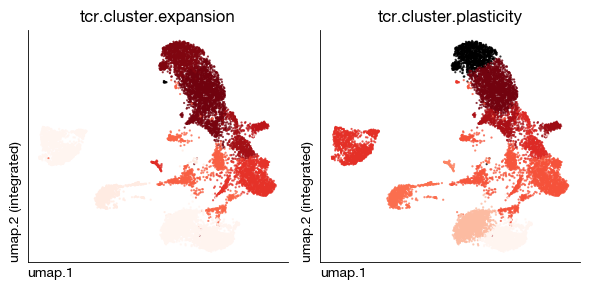

In [49]:
fig = expm.plot_rna_embedding_multiple(
    basis = 'umap', ncols = 2, features = [
        'tcr.cluster.expansion', 'tcr.cluster.plasticity', # 'tcr.cluster.ptrans'
    ],
    figsize = (6, 3), dpi = 100, legend_col = 2, legend = False,
    ptsize = 2, annotate_style = 'text', 
    cmap = 'reds'
)

### 保存数据集

保存整合的数据集

In [50]:
expm.save(save_samples = False)

[i] main dataset write to tcr/integrated.h5mu
